# Deer detection

This notebook uses the data from the following hugging face dataset "myyyyw/NTLNP" to train a small YoloV8 model to detect deer in images.

The training_data folder contains the downloaded data from the dataset, which has been extracted from the rar files.

In [ ]:
# For Google Colab
!git lfs install
!git clone https://huggingface.co/datasets/myyyyw/NTLNP

In [ ]:
# For Colab
! pip install huggingface_hub patool pylabel transformers pytorch_lightning

In [ ]:
import wandb
wandb.login()
#you can name your wandb project however you like, 
# #in this project you will be able to compare training runs
# project_name = "DeerDetection01"
# wandb.init(project=project_name)


In [1]:
# Download the hugging face dataset 'myyyyw/NTLP' and save it in the folder 'training_data'
import patoolib
import os
if os.path.exists('training_data'):
    data_folder = 'training_data'
else:
    data_folder = 'NTLNP'
filenames = ['voc_day.rar', 'voc_night.rar']


# Extract the two rar files
for rar_file in filenames:
    if os.path.exists(os.path.join(data_folder, rar_file.split('.')[0])):
        print(f'{rar_file} already extracted')
    else:
        patoolib.extract_archive(os.path.join(data_folder, rar_file), outdir=data_folder)

voc_day.rar already extracted
voc_night.rar already extracted


In [2]:
from pylabel import importer
import pandas as pd

day_annotation_folder = f'./{data_folder}/voc_day/Annotations/'
night_annotation_folder = f'./{data_folder}/voc_night/Annotations/'

path_to_images = "../JPEGImages/"

day_dataset = importer.ImportVOC(path=day_annotation_folder, path_to_images=path_to_images)
night_dataset = importer.ImportVOC(path=night_annotation_folder, path_to_images=path_to_images)

datasets = {
    "day": day_dataset,
    "night": night_dataset
}

Importing VOC files...: 100%|██████████| 10345/10345 [00:06<00:00, 1574.53it/s]


In [3]:
cat_mapping = dict(zip(datasets["day"].df['cat_id'].unique(), datasets["day"].df['cat_name'].unique()))

# Apply the same mapping to the night dataset
datasets["night"].df['cat_name'] = datasets["night"].df['cat_id'].map(cat_mapping)
datasets["night"].df['cat_id'] = datasets["night"].df['cat_name'].map(dict(zip(datasets["night"].df['cat_name'].unique(), datasets["night"].df['cat_id'].unique())))

night_cat_mapping = dict(zip(datasets["night"].df['cat_id'].unique(), datasets["night"].df['cat_name'].unique()))


In [4]:
import copy

datasets['day'].df['img_folder'] = '.'
datasets['day'].df['img_filename'] = datasets['day'].df['img_filename'].apply(lambda x: 'voc_day/JPEGImages/' + x)
datasets['night'].df['img_folder'] = '.'
datasets['night'].df['img_filename'] = datasets['night'].df['img_filename'].apply(lambda x: 'voc_night/JPEGImages/' + x)
datasets['combined'] = copy.deepcopy(datasets['day'])
datasets['combined'].df = pd.concat([datasets['day'].df, datasets['night'].df]).reset_index(drop=True)

# Shuffle the combined dataset and split into train val and test sets
test_size = 0.2
val_size = 0.1
train_size = 1 - test_size - val_size

datasets['combined'].df = datasets['combined'].df.sample(frac=1).reset_index(drop=True)

for key in ['train', 'val', 'test']:
    datasets[key] = copy.deepcopy(datasets['combined'])
    
datasets['train'].df = datasets['combined'].df.iloc[:int(train_size*len(datasets['combined'].df))].reset_index(drop=True)
datasets['val'].df = datasets['combined'].df.iloc[int(train_size*len(datasets['combined'].df)):int((train_size+val_size)*len(datasets['combined'].df))].reset_index(drop=True)
datasets['test'].df = datasets['combined'].df.iloc[int((train_size+val_size)*len(datasets['combined'].df)):].reset_index(drop=True)



In [5]:
for dataset_name, dataset in datasets.items():
    print(f"Dataset: {dataset_name}")
    print(f"Number of images: {dataset.analyze.num_images}")
    print(f"Number of classes: {dataset.analyze.num_classes}")
    print(f"Classes:{dataset.analyze.classes}")
    print(f"Class counts:\n{dataset.analyze.class_counts}")

Dataset: day
Number of images: 15313
Number of classes: 17
Classes:['Leopard', 'AmurTiger', 'Badger', 'BlackBear', 'Cow', 'RaccoonDog', 'Dog', 'Hare', 'LeopardCat', 'MuskDeer', 'RedFox', 'RoeDeer', 'Sable', 'SikaDeer', 'Weasel', 'WildBoar', 'Y.T.Marten']
Class counts:
SikaDeer      1849
RoeDeer       1686
WildBoar      1526
Cow           1364
Dog           1360
Leopard       1102
LeopardCat    1045
RedFox        1001
BlackBear      973
Y.T.Marten     968
Badger         955
AmurTiger      828
Weasel         755
RaccoonDog     352
MuskDeer       271
Sable          192
Hare            20
Name: cat_name, dtype: int64
Dataset: night
Number of images: 10344
Number of classes: 17
Classes:['Leopard', 'AmurTiger', 'Badger', 'BlackBear', 'Cow', 'RaccoonDog', 'Dog', 'Hare', 'LeopardCat', 'MuskDeer', 'RedFox', 'RoeDeer', 'Sable', 'SikaDeer', 'Weasel', 'WildBoar', 'Y.T.Marten']
Class counts:
MuskDeer      1264
Dog           1261
LeopardCat    1031
Hare           937
RedFox         872
WildBoar     

In [6]:
datasets['combined'].export.ExportToCoco(output_path='./training_data/coco_combined.json')
datasets['train'].export.ExportToCoco(output_path='./training_data/coco_train.json')
datasets['val'].export.ExportToCoco(output_path='./training_data/coco_val.json')
datasets['test'].export.ExportToCoco(output_path='./training_data/coco_test.json')


Exporting to COCO file...: 100%|██████████| 5390/5390 [00:01<00:00, 2858.19it/s]


['./training_data/coco_test.json']

In [7]:
combined_dataset = importer.ImportCoco(path='./training_data/coco_combined.json')

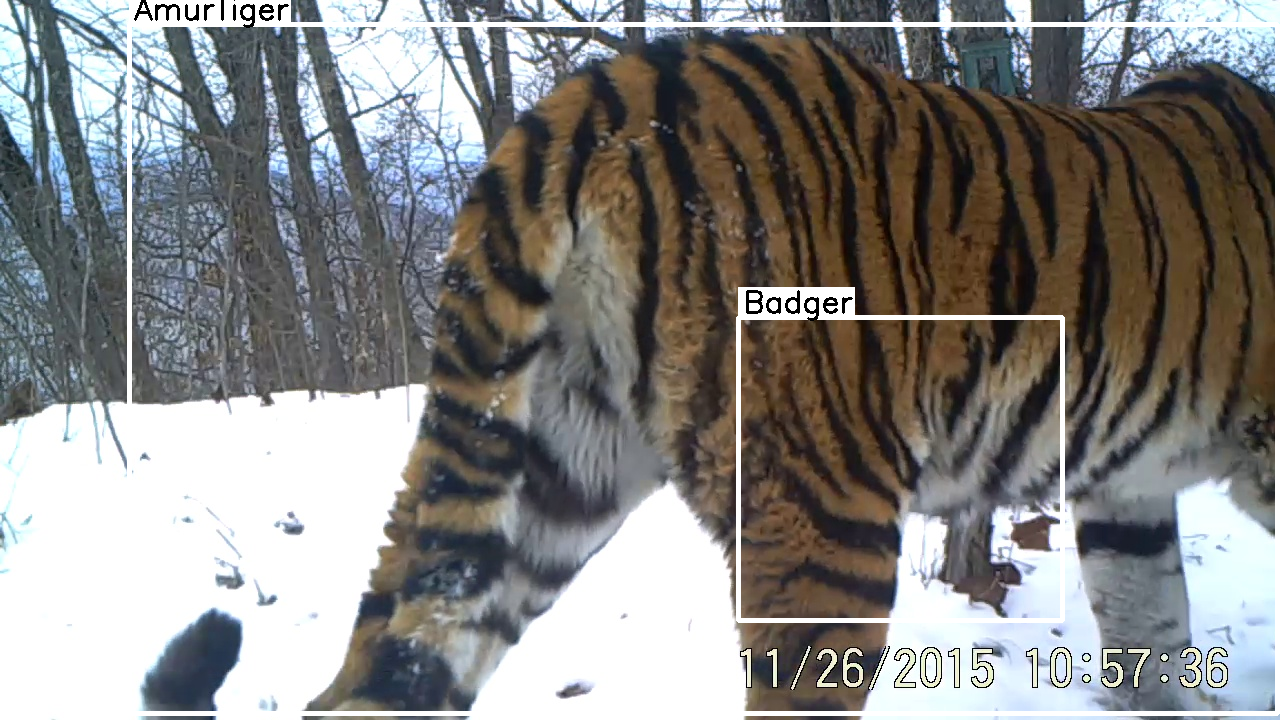

In [8]:
from IPython.display import Image, display
display(combined_dataset.visualize.ShowBoundingBoxes(1000))
# display(dataset.visualize.ShowBoundingBoxes("BloodImage_00315.jpg"))

In [2]:
import torchvision
import os
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, set):
        ann_file = os.path.join(img_folder, f"coco_{set}.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super().__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

train_dataset = CocoDetection(img_folder=data_folder, feature_extractor=feature_extractor, set='train')
val_dataset = CocoDetection(img_folder=data_folder, feature_extractor=feature_extractor, set='val')
test_dataset = CocoDetection(img_folder=data_folder, feature_extractor=feature_extractor, set='test')

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of testing examples:", len(test_dataset))

id2label = {k: v['name'] for k,v in train_dataset.coco.cats.items()}


c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of training examples: 12994
Number of validation examples: 2566
Number of testing examples: 4912


In [3]:
#Setup dataloader for training loop


def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

In [4]:

#we wrap our model around pytorch lightning for training
class YoloS(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.weight_decay = weight_decay
         self.save_hyperparameters()  # adding this will save the hyperparameters to W&B too

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("train/loss", loss)  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("train/" + k, v.item())  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss) # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("validation/" + k, v.item()) #  logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader
     
     def test_dataloader(self):
         return test_dataloader

In [10]:
model = YoloS(lr=2.5e-5, weight_decay=1e-4)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([18]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([18, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([18]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([18, 192]) in the model in

In [1]:

gpu_available = torch.cuda.is_available()

if not hasattr(torch._C, "_cuda_getDeviceCount"):
  raise("CUDA not compiled in PyTorch. Training on CPU")

if not gpu_available:
  raise("No GPU available. Training on CPU")


In [8]:

# Keep track of the checkpoint with the lowest validation loss
checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min", dirpath="checkpoints", filename="best-checkpoint")

# Name your wandb project and upload the final checkpoint to wandb, according to ModelCheckpoint
# Click on the output wandb run name below to see your metrics updating live in wandb
# wandb_logger = WandbLogger(project='roboflow-yolos', log_model=True)


In [9]:

torch.set_float32_matmul_precision('medium')
# Clear GPU cache
torch.cuda.empty_cache()
#more epochs leads to a tighter fit of your model to your data.
#we set epochs=10 here for an example of quick training
trainer = Trainer(max_epochs=11, gradient_clip_val=0.1, accumulate_grad_batches=8, #logger=wandb_logger,
                  log_every_n_steps=5, callbacks=[checkpoint_callback]) #  checkpoint_callback to log model to W&B at end of training and changed log_every_n_steps=5 to generate better charts
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:630: Checkpoint directory checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 6.5 M 
--------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.898    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [11]:
#clean up torch tensors before eval so your gpu memory doesn't crash!
torch.cuda.empty_cache()

In [26]:
#we borrow the eval scripts from the DETR repo as they provide similar functionality to what we need to calculate mAP
# !git clone https://github.com/facebookresearch/detr.git
# %cd /content/detr
%cp detr/datasets datasets -r


UsageError: Line magic function `%cp` not found.


In [12]:
import sys
from pathlib import Path
path = Path.cwd() / 'detr'
sys.path.insert(0, str(path))
sys.path.append(str(path))
%load_ext autoreload
%autoreload 2

In [13]:
# Load model from checkpoint
model = YoloS.load_from_checkpoint("checkpoints/best-checkpoint.ckpt")

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([18]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([18, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset)

In [15]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/2566 [00:00<?, ?it/s]

`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.


Accumulating evaluation results...
DONE (t=2.43s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.564
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [ ]:
# MORGAN: We can add final summary metrics to our wandb run using wandb.summary
wandb.summary['AP_IOU-0.5_all'] = 0.052

In [27]:
#We can use the image_id in target to know which image it is

# Get a random image from the test set


In [17]:
import torch
import matplotlib.pyplot as plt

#lower confidence yields more, but less accurate predictions
CONFIDENCE=0.2

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

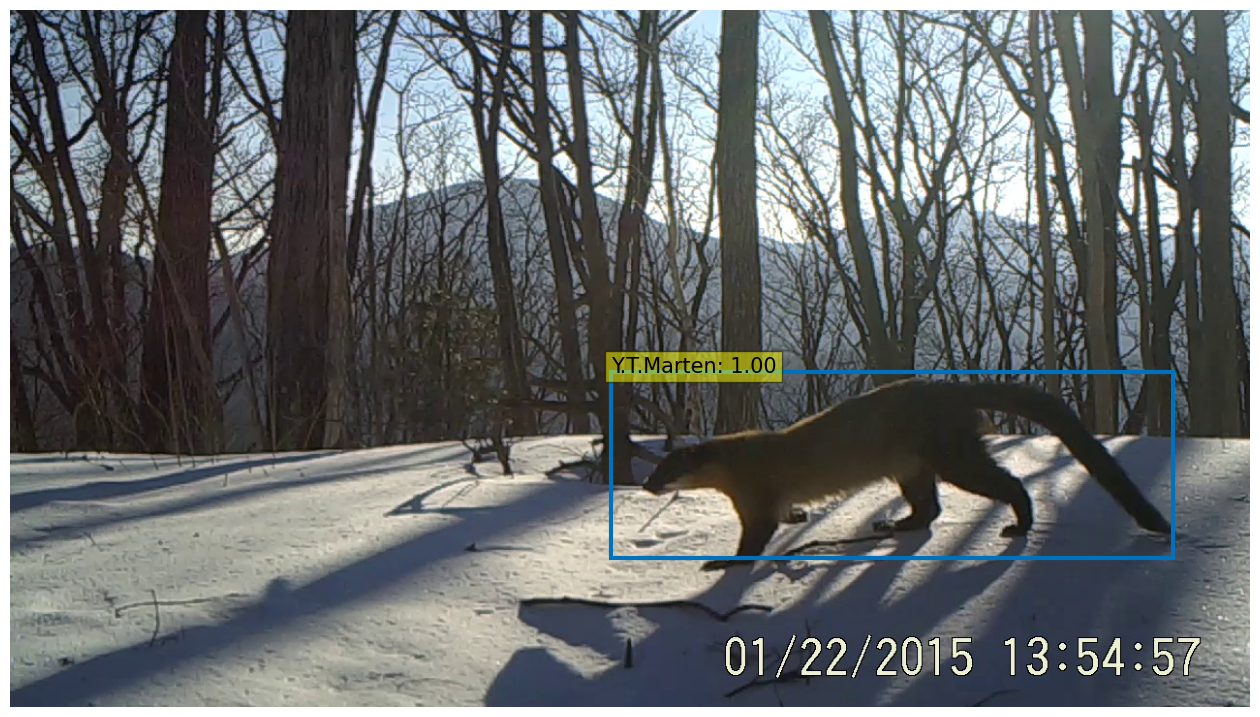

In [45]:
from PIL import Image, ImageDraw
import random

idx = random.randint(0, len(test_dataset))

pixel_values, target = test_dataset[idx]
pixel_values = pixel_values.unsqueeze(0).to(device)
outputs = model(pixel_values=pixel_values)

image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
filepath = os.path.join(data_folder, image['file_name'])
image = Image.open(filepath)

visualize_predictions(image, outputs)

In [20]:
# Next time need to:
# Change the evaluation so that it only considers the deer class, and treats all other classes as background
# Also we only care if it has predicted a deer, and dont care about the IoU, if there are multiple predictions that is fine also


{'id': 10,
 'folder': '.',
 'file_name': 'voc_day/JPEGImages/AmurLeopard_1011.jpg',
 'path': None,
 'width': 1280,
 'height': 720,
 'depth': '3'}